# 1 Non-Performing Loan Flag Prediction from Credit Card Information

Each year, non-performing loans cost the economy millions of baht. Predicting whether a
customer will default on their credit card loans is a non-trivial task, which if solved, can be
highly beneficial to both KBank and KBank’s customers. If default could be predicted in
advance, loans could be restructured, this would save customers from bankruptcy, and prevent
KBank from losing revenue.

The task is to use the data given to predict if customers defaulted on their credit card
loans in a certain period of time.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Beautiful format for float type
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## CSV to DataFrame

In [79]:
card_details = pd.read_csv('tj_01_creditcard_card.csv')
customer_details = pd.read_csv('tj_01_creditcard_customer.csv')
transactions = pd.read_csv('tj_01_creditcard_transaction.csv')

mcc_codes = pd.read_csv('mcc_codes.csv')

data_train = pd.read_csv('tj_01_training.csv', header = None, names = ['card_no', 'npl_flag'])
data_test = pd.read_csv('tj_01_test.csv', header = None, names = ['card_no'])

In [80]:
card_details = card_details.fillna(0)
card_details.isnull().values.any()

False

In [81]:
customer_details = customer_details.fillna(0)
customer_details.isnull().values.any()

False

In [82]:
transactions = transactions.fillna(0)
transactions.isnull().values.any()

False

In [83]:
mcc_codes = mcc_codes.fillna("0")
mcc_codes.isnull().values.any()

False

## Merge Related DataFrame

In [84]:
card_details = card_details.merge(customer_details, left_on = 'cst_id', right_on = 'cst_id', how = "left")
card_details.sample()

,card_no,bill_cyc,pos_dt_x,cst_id,open_dt,exp_dt,cr_lmt_amt,prev_cr_lmt_amt,incm_amt,age,main_zip_cd,cr_line_amt,pos_dt_y
8468,1234000000019638,5,2017-02-23 00:00:00,1000003333,2009-06-15 00:00:00,619,165000.000,265000.000,66190,51.000,10160,165000.000,2017-02-23 00:00:00


In [85]:
transactions = transactions.merge(mcc_codes, how = "left", left_on = "mer_cat_code", right_on = "mcc")
transactions.sample(3)

,card_no,txn_date,txn_hour,txn_amount,mer_cat_code,mer_id,mcc,edited_description,combined_description,usda_description,irs_description,irs_reportable
118761,1234000000004782,2016-02-04 00:00:00,19,1400.000,5631,0,5631.000,Women’s Accessory and Specialty Shops,Women’s Accessory and Specialty Shops,Women’s Accessory and Specialty Shops,Women’s Accessory and Specialty Shops,No1.6041-3(c)
50558,1234000000012213,2016-04-15 00:00:00,18,550.000,5311,0,5311.000,Department Stores,Department Stores,Department Stores,Department Stores,No1.6041-3(c)
574972,1234000000013126,2016-02-11 00:00:00,13,2000.000,6011,28725,6011.000,Financial Institutions – Manual Cash Disbursem...,Financial Institutions – Manual Cash Disbursem...,Financial Institutions – Manual Cash Disbursem...,Automated Cash Disburse,No1.6041-3(c)


## Cleanup Cards

In [5]:
card_details.sample()

,card_no,bill_cyc,pos_dt_x,cst_id,open_dt,exp_dt,cr_lmt_amt,prev_cr_lmt_amt,incm_amt,age,main_zip_cd,cr_line_amt,pos_dt_y
6931,1234000000016510,20,2017-02-23 00:00:00,1000002282,2006-11-27 00:00:00,1121,31000.000,32000.000,15623,38.000,10300,31000.000,2017-02-23 00:00:00


In [86]:
def cleanup_card_columns(df):
    drop_columns = ['pos_dt_x'
                    , 'bill_cyc'
                    , 'cst_id'
                    , 'open_dt'
                    , 'exp_dt'
                    , 'pos_dt_y']
    
    return df.drop(drop_columns, axis = 1)


def make_readable_columns(df):
    df.columns = ['card_no'
                  , 'credit_limit'
                  , 'prev_credit_limit'
                  , 'income'
                  , 'age'
                  , 'zip'
                  , 'credit_available']
    
    return df


def cleanup_cards(df):
    df = cleanup_card_columns(df)
    df = make_readable_columns(df)
    
    return df


clean_card_details = cleanup_cards(card_details)
clean_card_details.sample()

,card_no,credit_limit,prev_credit_limit,income,age,zip,credit_available
6614,1234000000012213,100000.000,240000.000,48204,34.000,11000,100000.000


## Cleanup Transactions

In [42]:
transactions.sample()

,card_no,txn_date,txn_hour,txn_amount,mer_cat_code,mer_id,mcc,edited_description,combined_description,usda_description,irs_description,irs_reportable
486820,1234000000026255,2016-06-11 00:00:00,19,450.000,4812,16783,4812.000,Telecommunications Equipment including telepho...,Telecommunications Equipment including telepho...,Telecommunications Equipment including telepho...,Telecommunication Equipment and Telephone Sales,No1.6041-3(c)


In [87]:
def cleanup_transaction_columns(df):
    drop_columns = ['mer_cat_code'
                    , 'mer_id'
                    , 'mcc'
                    , 'txn_hour'
                    , 'combined_description'
                    , 'usda_description'
                    , 'irs_description'
                    , 'irs_reportable']
    
    return df.drop(drop_columns, axis = 1)


def make_readable_columns(df):
    df.columns = ['card_no'
                  , 'date'
                  , 'amount'
                  , 'merchant']
    
    return df


def simplify_date(df):
    df['date'] = pd.to_datetime(df['date']).map(lambda x: x.strftime('%Y-%m'))
    
    return df


def cleanup_transactions(df):
    df = cleanup_transaction_columns(df)
    df = make_readable_columns(df)
    df = simplify_date(df)
    
    return df


clean_transactions = cleanup_transactions(transactions)
clean_transactions.sample()

,card_no,date,amount,merchant
334509,1234000000025246,2016-02,450.000,"Insurance Sales, Underwriting, and Premiums"


## Visualizing Data
### Card Detail

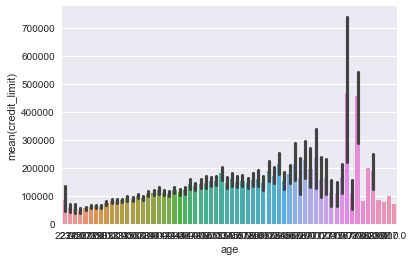

In [9]:
sns.barplot(data = clean_card_details, x = 'age', y = 'credit_limit')

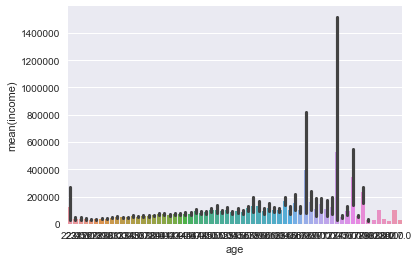

In [10]:
sns.barplot(data = clean_card_details, x = 'age', y = 'income')

### Transaction

In [11]:
# sns.distplot(data = clean_transactions, x = 'date', y = 'amount')

## Calculate mean amount of transactions

### Amount per month

In [88]:
transaction_amount_per_month = clean_transactions.groupby(['card_no', 'date']).sum().reset_index()
transaction_amount_per_month.head(6)

,card_no,date,amount
0,1234000000000004,2016-01,9500.000
1,1234000000000004,2016-02,3200.000
2,1234000000000004,2016-03,5200.000
3,1234000000000004,2016-04,4500.000
4,1234000000000004,2016-05,4400.000
5,1234000000000004,2016-06,2700.000


### Mean

In [89]:
transaction_mean = transaction_amount_per_month.groupby(['card_no']).mean().reset_index().fillna(0)
transaction_mean.head(6)

,card_no,amount
0,1234000000000004,4868.750
1,1234000000000005,312.500
2,1234000000000006,18800.000
3,1234000000000010,3756.250
4,1234000000000012,7406.250
5,1234000000000014,6587.500


### Merge to cards

In [90]:
clean_card_details_with_transaction_mean = clean_card_details.join(transaction_mean.set_index('card_no'), on = 'card_no', how = 'left')
clean_card_details_with_transaction_mean.sample(10)

,card_no,credit_limit,prev_credit_limit,income,age,zip,credit_available,amount
1952,1234000000026284,36000.000,0.000,18000,32.000,74130,36000.000,3475.000
6101,1234000000000139,48000.000,40000.000,182620,49.000,10500,208000.000,11368.750
729,1234000000008498,400000.000,401521.000,358333,52.000,10330,400000.000,16980.000
2154,1234000000014071,500000.000,260000.000,342615,48.000,20130,500000.000,35950.000
2567,1234000000026160,80000.000,110000.000,243200,52.000,10260,240000.000,12118.750
1687,1234000000015295,100000.000,0.000,73991,45.000,43000,100000.000,6500.000
8511,1234000000014467,18000.000,0.000,15136,26.000,50300,18000.000,1768.750
2529,1234000000023653,40000.000,0.000,21770,37.000,10540,40000.000,3842.857
7985,1234000000003191,52000.000,62400.000,31875,41.000,11120,52000.000,4200.000
2145,1234000000021161,78000.000,0.000,52055,47.000,22120,78000.000,8042.857


## WIP: Pivot  Merchant

## Splitting up the training Data

In [91]:
data_train_with_details = data_train.join(clean_card_details_with_transaction_mean.set_index('card_no'), on = 'card_no', how = 'left')
data_train_with_details.sample()

,card_no,npl_flag,credit_limit,prev_credit_limit,income,age,zip,credit_available,amount
3108,1234000000020764,0,77000.000,0.000,22000,86.000,10600,77000.000,3793.750


In [92]:
from sklearn.model_selection import train_test_split

X_all = data_train_with_details.drop(['card_no', 'npl_flag'], axis=1)
y_all = data_train_with_details['npl_flag']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [93]:
X_train.shape

(7600, 7)

## Fitting and Tuning an Classifier

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [100], 
              'max_features': ['log2', 'sqrt', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [111]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.757894736842


## Validate with KFold

In [112]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.6777777777777778
Fold 2 accuracy: 0.7303370786516854
Fold 3 accuracy: 0.7752808988764045
Fold 4 accuracy: 0.7303370786516854
Fold 5 accuracy: 0.7191011235955056
Fold 6 accuracy: 0.6853932584269663
Fold 7 accuracy: 0.7078651685393258
Fold 8 accuracy: 0.7528089887640449
Fold 9 accuracy: 0.7303370786516854
Fold 10 accuracy: 0.7752808988764045
Mean Accuracy: 0.7284519350811487


## Predict the Actual Test Data

In [114]:
test = data_test.join(clean_card_details_with_transaction_mean.set_index('card_no'), on = 'card_no', how = 'left')
predictions = clf.predict(test.drop('card_no', axis=1))


output = pd.DataFrame({'npl_flag': predictions })
output.to_csv('3.csv', index = False, header = None)
output.head(100)

,npl_flag
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0
